# Base Model: Logistic Regression

## Date: Nov 9, 2023

------------------

## Introduction

In this notebook, a baseline classification model will be implemented using Logistic Regression. Log reg is a good baseline as it is one of the simplest classification models, offers high explainability, and is computationally light compared some of to its counterparts. 

The steps:  
After the data is read in, basic assumptions are established and checked. Any features that show high colinearity and multicollinearity are removed. Then 3 iterations of log reg will be run.
1. Unbalanced unscaled dataset: Demonstrate how balancing the dataset affects the model's performance. 
2. Balanced scaled dataset. The first baseline model. No hyperparameter tuning
3. Optimized model. A optimized model will be used by varying the solver, iterations, regulatization to achieve the best stable baseline log reg model.

Evaluation will be focused on the 2nd and 3rd iterations as those showed significant improvements.  

Note:
- n_jobs can be increased if you have more cpu cores to speed up the modelling
- vif calculations and the gridsearch at the end can take a few minutes to run

----------------

### Table of Contents

1. [Introduction](#Introduction)
   - [Table of Contents](#Table-of-contents)
   - [Import Librarys](#Import-Librarys)
   - [Data Dictionary](#Data-Dictionary)
   - [Define Functions](#Define-Functions)
   - [Load the data](#Load-the-data)
3. [Logistic Regression Model](#Logistic-Regression-Model)
   - [Assumptions](#Assumptions)
   - [PreProcessing](#PreProcessing)
   - [Modelling](#Modelling)
   - [Evaluation](#Evaluation)
8. [Conclusion](#Conclusion)


### Import Librarys

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, , f1_score, 
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.utils import resample
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay

from tempfile import mkdtemp
from pathlib import Path
from joblib import dump
from statsmodels.stats.outliers_influence import variance_inflation_factor

from helpers import display_corr_heatmap, data_dict

### Data Dictionary

Display the data dictionary. Reminder to place it under the `/Data/Lending_club/` directory like the data.

In [2]:
data_dict()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


### Load the Data

In [3]:
# Define the relative path to the file
parquet_file_path = Path('../Data/Lending_club/model_cleaned')

try:
    # Read the parquet file
    loans_df = pd.read_parquet(parquet_file_path)
except FileNotFoundError as e:
    print(e.args[1])
    print('Check file location')

In [4]:
loans_df.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
50867,23000.0,36,12.05,764.479980,3.0,RENT,50000.0,Source Verified,1,debt_consolidation,13.900000,0.0,1.0,8.0,0.0,9976.0,45.599998,12.0,0.0,Individual,0.0,0.0,11973.0,21900.0,2.0,1710.0,11924.0,45.599998,0.0,0.0,110.0,119.0,5.0,5.0,0.0,5.0,2.0,4.0,4.0,4.0,6.0,5.0,5.0,7.0,4.0,8.0,0.0,1.0,81.800003,0.000000,0.0,0.0,28207.0,11973.0,21900.0,6307.0
373353,35000.0,60,17.57,880.609985,2.0,RENT,110000.0,Verified,1,debt_consolidation,31.629999,0.0,0.0,27.0,0.0,50450.0,75.599998,38.0,0.0,Individual,0.0,541.0,304808.0,66700.0,3.0,11289.0,9169.0,81.599998,0.0,0.0,138.0,193.0,11.0,3.0,1.0,47.0,0.0,7.0,10.0,8.0,13.0,17.0,14.0,19.0,10.0,27.0,0.0,3.0,91.900002,50.000000,0.0,0.0,336948.0,215616.0,49900.0,134250.0
185185,33100.0,36,13.99,1131.119995,1.0,MORTGAGE,72000.0,Source Verified,1,debt_consolidation,12.130000,0.0,2.0,10.0,0.0,16993.0,37.599998,29.0,0.0,Individual,0.0,89.0,33172.0,45200.0,3.0,3686.0,8802.0,64.800003,0.0,0.0,143.0,247.0,10.0,10.0,0.0,43.0,0.0,3.0,4.0,3.0,9.0,7.0,9.0,22.0,4.0,10.0,0.0,1.0,100.000000,33.299999,0.0,0.0,67371.0,33172.0,25000.0,22171.0
33164,1000.0,36,11.22,32.849998,10.0,RENT,40000.0,Verified,1,vacation,18.270000,0.0,1.0,9.0,0.0,12175.0,39.799999,13.0,0.0,Individual,0.0,0.0,25333.0,30600.0,5.0,2815.0,17325.0,41.299999,0.0,0.0,19.0,132.0,1.0,1.0,0.0,1.0,0.0,4.0,4.0,6.0,8.0,2.0,7.0,11.0,4.0,9.0,0.0,3.0,100.000000,16.700001,0.0,0.0,46125.0,25333.0,29500.0,15525.0
368586,4400.0,36,12.29,146.759995,3.0,RENT,34000.0,Verified,1,debt_consolidation,8.860000,0.0,0.0,6.0,0.0,10915.0,78.000000,17.0,0.0,Individual,0.0,0.0,10915.0,14000.0,0.0,2183.0,1985.0,84.599998,0.0,0.0,123.0,172.0,29.0,29.0,0.0,33.0,0.0,4.0,4.0,4.0,9.0,3.0,6.0,14.0,4.0,6.0,0.0,0.0,100.000000,100.000000,0.0,0.0,14000.0,10915.0,12900.0,0.0


## Logistic Regression Model

-------------

### Assumptions 

Before we can start modeling, some base assumptions must be met in order to use a log reg model.   
These include:  
* **Binary Outcome:** The dependent variable is a binary. This is met as loan status has been encoded as 1 and 0
* **Independence:** It is reasonable to assume loans are independent. Without identifiable information, there is not way of knowing from the dataset whether a borrower has applied for multiple loans as the member_id data has been removed by lendingclub.
* **No collinearity / multicollinearity.** Can lead to unstable coefficient estimates and interpretation difficulty. This will be checked
* **Sufficiently Large sample size:** More than 100,000 loans. This is met

### Colinearity

Plot a correlation heatmap for the remaining features.

C:\Users\pags\.conda\envs\loans_capstone\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


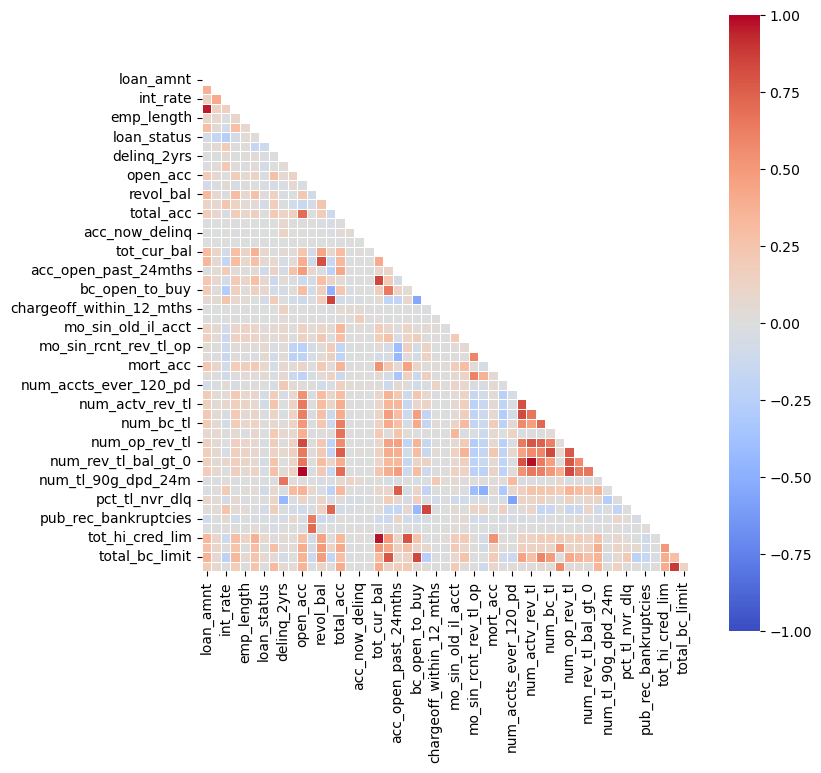

In [5]:
display_corr_heatmap(loans_df)

There are some features with high colinearity, such as `open_acc`, `total_acc`, etc. These are primarily from the applicants credit report.

### Collinearity / Multicollinearity

Check for multicollinearity and collineartiy before we split the data or encode categorical variables. First check for multicollinearity using Variance Inflation Factor (VIF). 

Create a df to hold the vif scores. Calculate the vif scores for each feature and place in the dataframe. This may take a few moments as it is running a linear regression for each feature against all others.

In [6]:
%%time
# Define a vif threshold. 5 and 10 are standard 
vif_cutoff = 10

# Select only numeric features
numeric_df = loans_df.select_dtypes(include=[np.number])

# Create a dataframe to hold the vif scores for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_df.columns

# Calculate the vif
print('Running vif calculations...')
vif_data['VIF'] = [variance_inflation_factor(numeric_df.values, i) for i in range(len(numeric_df.columns))]
print('Finished vif calculations')

Running vif calculations...
Finished vif calculations
CPU times: total: 24min 19s
Wall time: 5min 40s


In [7]:
vif_data.sort_values(by=['VIF'], ascending=False)

,feature,VIF
10,open_acc,2697.799057
41,num_sats,2688.778991
14,total_acc,1911.790347
39,num_rev_accts,712.480533
37,num_il_tl,321.931970
0,loan_amnt,210.156224
3,installment,187.684284
40,num_rev_tl_bal_gt_0,141.797525
34,num_actv_rev_tl,134.112197
1,term,107.120621


Create a list of the columns with a vif greater than the threshold

In [8]:
high_vif_columns = vif_data[vif_data['VIF'] > vif_cutoff]['feature'].tolist()

Before dropping the features with high vif, inspect them

In [9]:
display(high_vif_columns)

['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'bc_open_to_buy',
 'bc_util',
 'mort_acc',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'pct_tl_nvr_dlq',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit']

We will leave `loan_amnt`, `term`, `int_rate`, as these are key features of the dataset.

In [10]:
# Drop features with high VIF
filtered_high_vif_columns = [feature for feature in high_vif_columns if feature not in ['loan_amnt', 'term', 'int_rate']]
loans_df.drop(columns = filtered_high_vif_columns, inplace=True)

The remaining features:

In [11]:
loans_df.head(0)

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,acc_open_past_24mths,avg_cur_bal,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,num_accts_ever_120_pd,num_tl_90g_dpd_24m,num_tl_op_past_12m,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens


***Collinearity***

C:\Users\pags\.conda\envs\loans_capstone\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


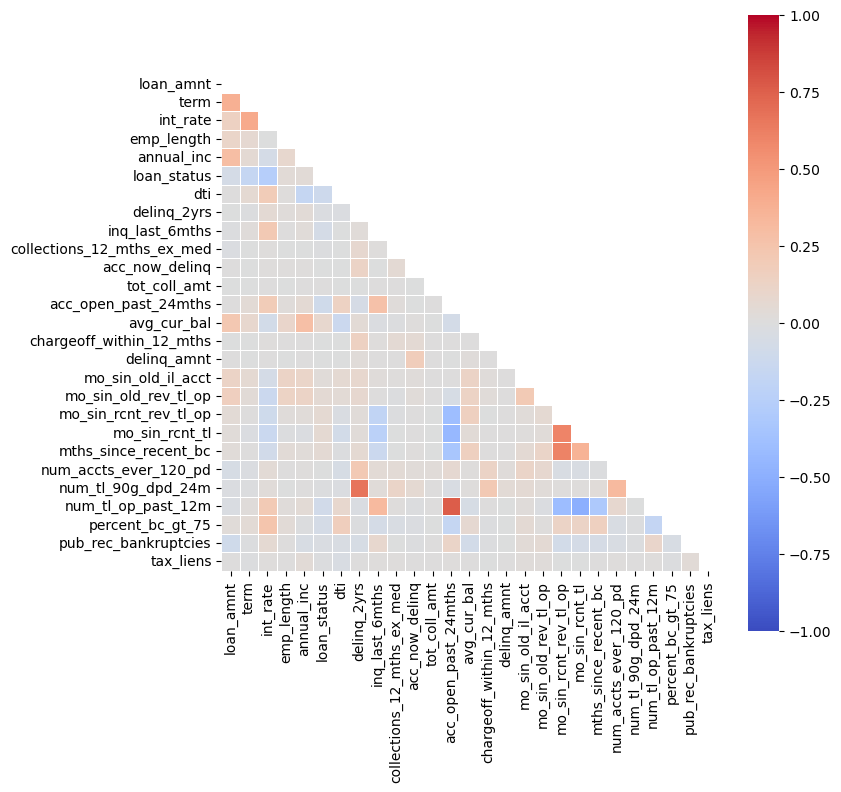

In [12]:
display_corr_heatmap(loans_df)

In [13]:
loans_df.drop(columns = ['num_tl_op_past_12m'], inplace=True)

There are still some high correlations between variables specifically `num_tl_op_past_12m`, the number of accounts opened in the past 12 months, with
`acc_open_past_24mths`, the number of trades opened the last 24 months. Although the correlation is moderately high, there is no redundancy as they represent different aspects of the credit report, so both will be kept. There are no major features highly correlated with the target variable.  
All the assumptions have now been met

### PreProcessing

***Train Test Split***

In [14]:
# Split the data
X = loans_df.drop(columns=['loan_status'], inplace=False)
y = loans_df['loan_status']

# Split into train and test sets. Stratify to ensure any inbalance is preserved as in the original data and not lost by random chance. 
# Create seperate splits for the unbalanced and balanced model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11, stratify=y)
unbal_X_train, unbal_X_test, unbal_y_train, unbal_y_test = train_test_split(X, y, test_size=0.3, random_state=11, stratify=y)

***Data Inbalance***

As shown in EDA, there is a large inbalance between the number of successful loans (class 1) and failed loans (class 0), approximately 80/20. Since the dataset is sufficiently large, it is acceptable to downsample the instances of class 1 to equal class 0. Balancing the dataset reduces the risk of any bias introduced to a single class simply due to its frequency in the dataset.  

This also has the added advantage of giving a more manageable dataset size. However, if computation power is not an issue, then more failed loans could be sampled from the original dataset, and / or synthetic data created for the minority class using SMOTE.  
More information can be found here:  
https://towardsdatascience.com/smote-fdce2f605729

In [15]:
print('Number of class 1 examples before:', X_train[y_train == 1].shape[0])

# Downsample majority class without replacement to the same size of the minority class
X_downsampled, y_downsampled  = resample(X_train[y_train == 1],
                                   y_train[y_train == 1],
                                   replace=False,
                                   n_samples=X_train[y_train == 0].shape[0],
                                   random_state=1)

print('\nNumber of class 1 examples after:', X_downsampled.shape[0])

Number of class 1 examples before: 247290

Number of class 1 examples after: 65003


Can now combine with the original dataset.

In [16]:
# Combine the downsampled successful loans with the failed loans
X_train_bal = pd.concat([X_train[y_train == 0], X_downsampled])
y_train_bal = np.hstack((y_train[y_train == 0], y_downsampled))

print("New X_train shape: ", X_train_bal.shape)
print("New y_train shape: ", y_train_bal.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

New X_train shape:  (130006, 29)
New y_train shape:  (130006,)
X_test shape:  (133841, 29)
y_test shape:  (133841,)


***Inspect Categorical Features***

Inspect whether the categorical features are ordinal or nominal. 

In [17]:
categorical_columns = X_train_bal.select_dtypes('object').columns.tolist()
display(categorical_columns)
categorical_columns.remove('verification_status')

['home_ownership', 'verification_status', 'purpose', 'application_type']

In [18]:
X_train_bal['verification_status'].value_counts()

verification_status
Source Verified    52789
Verified           42016
Not Verified       35201
Name: count, dtype: int64

The feature `verification_status` will be **ordinal encoded** since loan applications with verified income information should be weighted higher than those that are only source verified or unverified. The other categorical features can be onehot encoded.

***Column Transformation for 1st iteration***

Just encode the categorical variables as described above.

In [19]:
# Instantiate
unbal_categorical_transformer = OneHotEncoder(handle_unknown='ignore')
unbal_ordinal_transformer = OrdinalEncoder(categories=[['Not Verified', 'Source Verified', 'Verified']])

# Instantiate the column transformer
unbal_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', unbal_categorical_transformer, ['home_ownership', 'purpose', 'application_type']),
        ('ord', unbal_ordinal_transformer, ['verification_status']),
    ],
    remainder='passthrough',
    n_jobs=2 #use 2 cpu cores for greater speed
)

# Fit to the train set
unbal_preprocessor.fit(unbal_X_train)

# Transform the train and test sets
unbal_X_train_transformed = unbal_preprocessor.transform(unbal_X_train)
unbal_X_test_transformed = unbal_preprocessor.transform(unbal_X_test)

print("Shape of train transformed: ", unbal_X_train_transformed.shape)
print("Shape of test transformed: ",  unbal_X_test_transformed.shape)

Shape of train transformed:  (312293, 46)
Shape of test transformed:  (133841, 46)


***Column Transformation for 2nd Iteration***

For the second iteration, a standard scaler is fit as well. Although log reg is not a distance based model, it can aid in model performance by reducing the size of the parameter space, allowing the model to converge more easily.  
More information can be found here:  
https://forecastegy.com/posts/does-logistic-regression-require-feature-scaling/

In [20]:
# Instantiate
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(categories=[['Not Verified', 'Source Verified', 'Verified']])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ['home_ownership', 'purpose', 'application_type']),
        ('ord', ordinal_transformer, ['verification_status']),
        ('num', StandardScaler(), make_column_selector(dtype_include=['int64','int32','float64','float32']))
    ],
    remainder='passthrough',
    n_jobs=2
)

# Fit to the train set
preprocessor.fit(X_train_bal)

# Transform the train and test sets
X_train_transformed = preprocessor.transform(X_train_bal)
X_test_transformed = preprocessor.transform(X_test)

print("Shape of train transformed: ", X_train_transformed.shape)
print("Shape of test transformed: ", X_test_transformed.shape)

Shape of train transformed:  (130006, 46)
Shape of test transformed:  (133841, 46)


***Run the model 1st iteration***

The log reg models are ready to be run. A log reg model will be run on both the balanced downsampled data as well as the inbalanced data, to showcase model evaluation wrt to class balance. The log reg model will use the `lbfgs` solver as it performs well on small dataset, even though it may not converge. If the model does not converge, we will check for any features with high multicollinearity, and try a different solver and/ or higher iteration count.  

In [21]:
# Initializing and training the logistic regression model
unbal_log_reg = LogisticRegression(random_state=1,
                             solver='lbfgs', 
                             max_iter=4000, 
                             verbose=2, # Output while the model runs
                             n_jobs=2) # Use 2 cpu cores
                             #class_weight='balanced') #weight the minority class to counter inbalance also works

unbal_log_reg.fit(unbal_X_train_transformed, unbal_y_train)

# Making predictions on the test data using the trained model
unbal_y_pred = unbal_log_reg.predict(unbal_X_test_transformed)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:  1.6min finished


***Score the 1st iteration model***

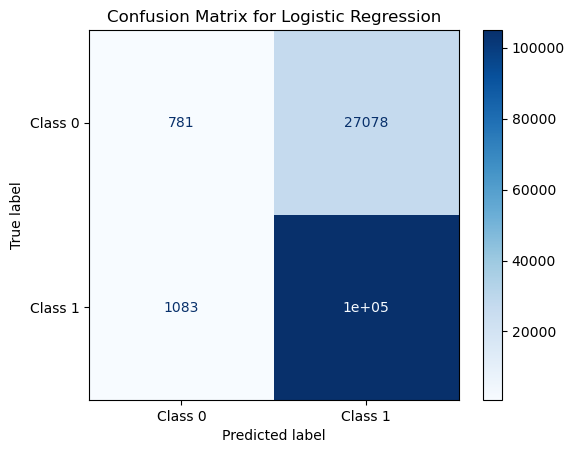

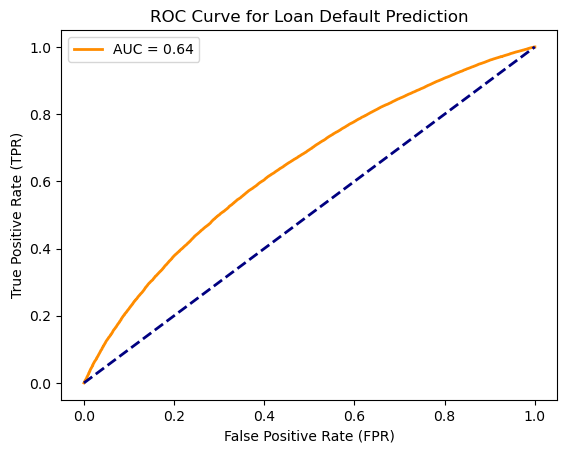

Area under curve (AUC):0.6410579637922771
--------------------
Confusion matrix:
[[   781  27078]
 [  1083 104899]]
--------------------
              precision    recall  f1-score   support

           0       0.42      0.03      0.05     27859
           1       0.79      0.99      0.88    105982

    accuracy                           0.79    133841
   macro avg       0.61      0.51      0.47    133841
weighted avg       0.72      0.79      0.71    133841

--------------------
Score on train: 0.7901201756043204
Score on test: 0.7895936222831569
--------------------


In [22]:
# Score the model on both train and test data
unbal_train_score = unbal_log_reg.score(unbal_X_train_transformed, unbal_y_train)
unbal_test_score = unbal_log_reg.score(unbal_X_test_transformed, unbal_y_test)

conf_matrix = confusion_matrix(unbal_y_test, unbal_y_pred)
class_report = classification_report(unbal_y_test, unbal_y_pred)

# Display the Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    unbal_log_reg, 
    unbal_X_test_transformed, 
    unbal_y_test, 
    cmap='Blues', 
    display_labels=['Class 0', 'Class 1']
)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

#################################
# Calculate the ROC curve

# Calculate the probability scores
probs = unbal_log_reg.predict_proba(unbal_X_test_transformed)

# Keep only the positive class (class 1)
probs = probs[:, 1]

# Pull out the fprs, tprs, and thresholds
fprs, tprs, thresholds = roc_curve(unbal_y_test, probs)
roc_auc = roc_auc_score(unbal_y_test, probs)

# Plot the ROC curve
plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Loan Default Prediction')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
#################################

# Print the confusion matrix and Classification Report
print("-"*20)
print("Confusion matrix:")
print(conf_matrix)
print("-"*20)
print(class_report)
print("-"*20)

print(f'Score on train: {unbal_train_score}')
print(f'Score on test: {unbal_test_score}')
print("-"*20)

As a scaled balanced dataset will almost guaranteed perform better, a brief evaluation on the confusion matrix and classification report will be sufficient to justify balancing the dataset. At first glance, the model seems to have performed well with a ~ 78.8% accuracy for both train and test sets. However, when considered with the class inbalance of 73.7%, a 78.7% accuracy is a small improvement over random guesswork. This inbalance results in the model predicting class 1 more frequently, resulting in a very high recall score for successful loans. Of all the successful loans, 99% were correctly identified, meaning there were very successful lending opportunities were missed. However, this came at a cost. For failed loans, the precision is very low, with a terrible recall. Indiscriminately predicting many loans to be successful led to a high number of false positives, with failed loans being misclassified as successful. This would result in a much higher credit risk. Of all the failed loans, only 3% were correctly identified (recall), with 42% of loans predicted as failed, actually failed (precision). The low precision would result in many missed lending oppertunites, with the low recall resulting in a very high credit risk. 

The weighted combined f1 score, an average for the precision and recall, is moderate at 0.71, showing overall a weak differentiation between successful and failed loans. However, this metric has less value considering the class inbalance. 

The ROC curve shows that the model is doing better than random choice (the horizontal line). The AUC of of 0.64 implies that when randomly selecting one positive and one negative example, the model will correctly assign a higher probability of being positive to the positive example about 64% of the time. Ideally, an AUC score closer to 1 would be preferred since that requires a higher TPR and lower FPR. 

Overall, this model correctly predicted many successful loans, at the cost of classifying many bad loans as successful. 
In the next iteration with a balanced scaled dataset, the aim will be to maintain a comparable precision, while minimizing false positives, resulting in a better balance between real credit opportunities and managing default risks. 

***Run the model 2nd iteration***

In [23]:
# Initializing and training the logistic regression model
log_reg = LogisticRegression(random_state=1,
                             solver='lbfgs', 
                             max_iter=4000, 
                             verbose=2, #output while the model runs
                             n_jobs=2) #use 2 cpu cores

log_reg.fit(X_train_transformed, y_train_bal)

# Making predictions on the test data using the trained model
y_pred_bal = log_reg.predict(X_test_transformed)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    5.7s finished


***Score the 2nd iteration model***

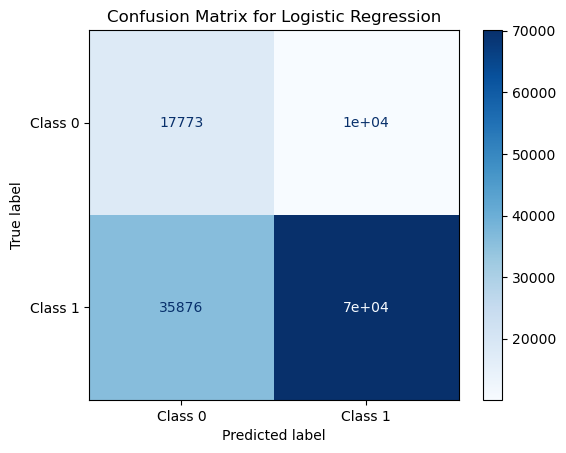

--------------------
Confusion matrix:
[[17773 10086]
 [35876 70106]]
--------------------
              precision    recall  f1-score   support

           0       0.33      0.64      0.44     27859
           1       0.87      0.66      0.75    105982

    accuracy                           0.66    133841
   macro avg       0.60      0.65      0.59    133841
weighted avg       0.76      0.66      0.69    133841

--------------------
Score on train: 0.6501469162961709
Score on test: 0.6565925239650032


In [24]:
# Score the model on both train and test data
train_score = log_reg.score(X_train_transformed, y_train_bal)
test_score = log_reg.score(X_test_transformed, y_test)

# Evaluating the model with confusion matrix and a classification report
conf_matrix = confusion_matrix(y_test, y_pred_bal)
class_report = classification_report(y_test, y_pred_bal)

# Display the confusion matrix
ConfusionMatrixDisplay.from_estimator(
    log_reg, 
    X_test_transformed, 
    y_test, 
    cmap='Blues', 
    display_labels=['Class 0', 'Class 1']
)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

print("-"*20)
print("Confusion matrix:")
print(conf_matrix)
print("-"*20)
print(class_report)
print("-"*20)

print(f'Score on train: {train_score}')
print(f'Score on test: {test_score}')

### Interpretation

The model has~ 65.0%% accuracy on the train set and~ 65.6% accuracy on the test set. The score between the train and test set are close,  meaning the model generalizes well to unseen data, and that there is no overfitting or underfitting. However, this will be further explored with the classification report. 

The confusion matrix above shows the counts for correctly and incorrectly predicted classes, in the format of:  
```
Predicted Label 
    0      1 
+------+------+  
| TP   |  FP  |  0
+------+------+     True Label
| FN   |  TN  |  1
+------+------+  
```


Where,
- **True Negative (TN):**177738 loans were correctly predicted as failed (class 0).
- **False Positive (FP):**10086 cases were incorrectly predicted as successful (class 1) when they are actually failed (class 0).
- **False Negative (FN):**35876 cases were incorrectly predicted as failed (class 0) when they are actually successful (class 1).
- **True Positive (TP):**70106 cases were correctly predicted as successful (class 1).  

The model showed a strong ability to discern successful from failed loans, with the majority of successful loans being accurately identified.
For this project, the primary goal is to minimize false positives, ie instance of failed loans incorrectly predicted as successful, minimizing credit default risk. Of the 27,859 failed loans, 17,788 were correctly predicted as failed, and of the 105,982 successful loans, 70,099 were correctly predicted as successful. While the model will be tuned for precision, however, this can be adjusted based on the lenders risk appetite, allowing for a more balanced approach between granting credit and managing default risks.


Classification Report
- **Precision for Class 0:** 0.33, meaning when the model predicts failed, it is correct ~ 33% of the time.
- **Recall for Class 0:** 0.64, meaning that the model correctly identifies ~ 64% of the actual failed cases.
- **F1-Score for Class 0:** 0.44, a weighted average of precision and recall for failed loans, indicating a moderate balance between precision and recall for this class.
- **Support for Class 0:** There are 27,859 actual occurrences of failed loans in the dataset. 

- **Precision for Class 1:** 0.87, suggesting that when the model predicts successful, it is correct ~ 87% of the time.
- **Recall for Class 1:** 0.66, meaning that the model correctly identifies ~ 66% of the actual successful cases.
- **F1-Score for Class 1:** 0.75, n  average of precision and recall for successful loans, indicating a strong balance between precision and recall for the successful class.
- **Support for Class 1:** There are 105,982 actual occurrences of successful loans in the dataset.

Overall Metrics
- **Accuracy:** 0.66, indicating that the overall, the model correctly predicts 66% of the cases.
- **Macro Average Precision:** 0.60, the average precision across both classes.
- **Macro Average Recall:** 0.65, the average recall across both classes.
- **Macro Average F1-Score:** 0.59, the average F1-score across both classes  .
Compared to the previous iteration, this model has made significant improvement. The precision for class 1 increased from 0.79 -> 0.86, meaning fewer bad loans were misclassified. The increase in precision came at the cost of recall, which decreased from 0.99 to 0.66. Fewer good lending opportunities were captured. However, the recall for failed loans increased from 0.03 to 0.64, meaning the model identified many more bad loans correctly. The f1 score decreased slightly, but the AUC increased. The model improved in distinguishing between both classes.

***Threshold Optimization***

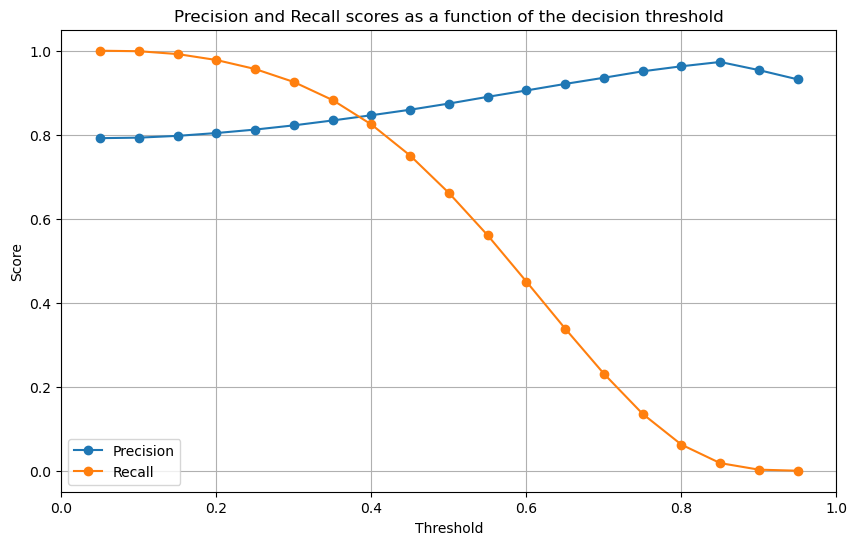

In [25]:
# Get the probabilities for the positive class
y_proba = log_reg.predict_proba(X_test_transformed)[:, 1]

# Vary thresholds by 0.05 from 0.05 to 1
thresholds = np.arange(0.05, 1, 0.05)

precisions = []
recalls = []

for threshold in thresholds:
    # Apply threshold
    y_threshold = np.where(y_proba > threshold, 1, 0)
    
    # Calculate precision and recall
    precision = precision_score(y_test, y_threshold)
    recall = recall_score(y_test, y_threshold)
    
    # Append to list
    precisions.append(precision)
    recalls.append(recall)

# Visualize the result
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.title('Precision and Recall scores as a function of the decision threshold')
plt.xlim(0, 1)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

As mentioned above, precision is preferred to recall for this project, as we want to only extend credit to worthy borrowers that are less likely to default, even if that comes at the cost of some missed lending opportunities. A threshold of 0.4 or 0.5 is appropriate here as afterward recall begins to steeply decrease. Once again, this can be varied based on lender risk tolerances.

***ROC Curve***

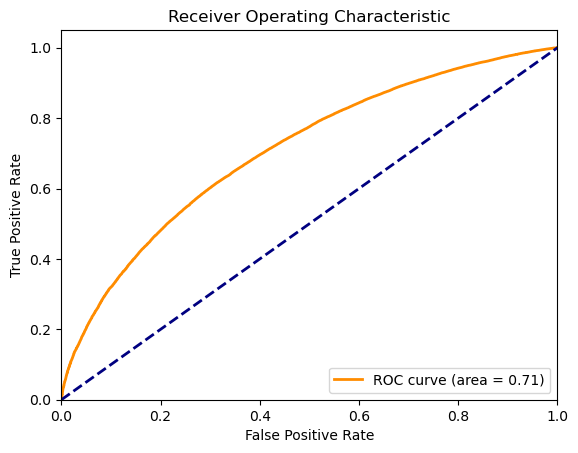

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The increased AUC score means for a certain threshold, the FPR to TPR has been improved, meaning the model is able to better discern betweem classes. 

***Feature importance***

Explore which features were most useful in the prediction be inspecting their weights, keeping in mind to look for any missed leaky features remaining. 

In [27]:
# Get the feature weights out. 
feature_weights = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'Coefficient': log_reg.coef_[0]
})

# Sort the features by the absolute value of their coefficient
feature_weights = feature_weights.sort_values(by='Coefficient', ascending=True)

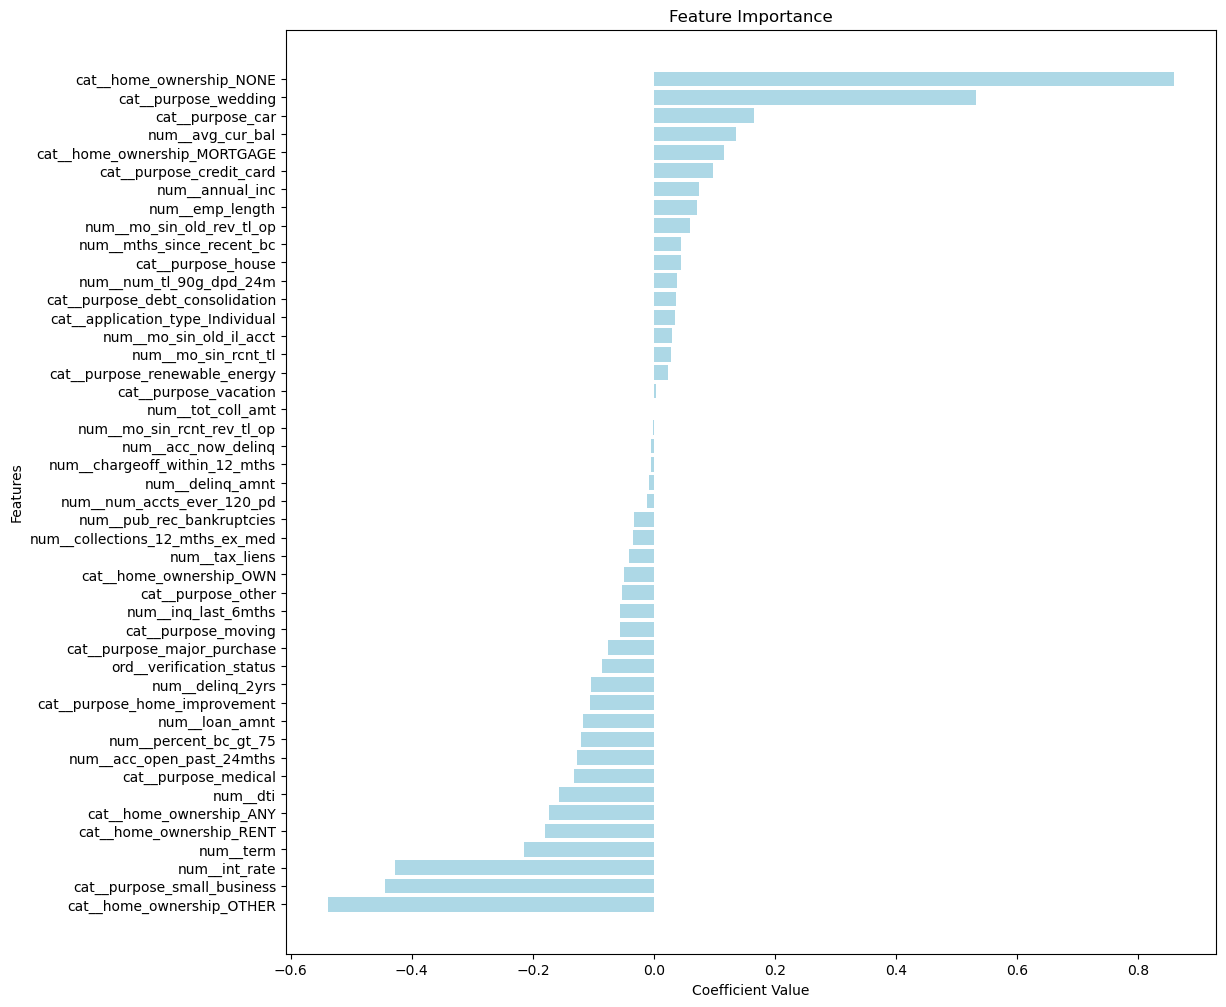

In [28]:
# Plotting the feature weights
plt.figure(figsize=(12, 12))
plt.barh(feature_weights['Feature'], feature_weights['Coefficient'], color='lightblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

The categorical features home ownership and loan purpose are the most positively predictive, with the home ownership, interest rate, and loan term being the most negatively predictive.  
Note:  
- "cat prefix indicates it was a categorical variable, and the "remainder" prefix can be ignored. It is left over from the columntransformer. 

***Log odds***

In [29]:
log_odds = log_reg.coef_[0]
odds = np.exp(log_odds)

feature_names = preprocessor.get_feature_names_out()
odds_df = pd.DataFrame({'Feature': feature_names, 'LogOdds': log_odds, 'OddsRatio': odds})

#sort df by OddsRatio
odds_df = odds_df.sort_values(by='OddsRatio', ascending=False)
odds_df

,Feature,LogOdds,OddsRatio
2,cat__home_ownership_NONE,0.858958,2.360699
18,cat__purpose_wedding,0.532043,1.702407
6,cat__purpose_car,0.164724,1.179068
33,num__avg_cur_bal,0.135312,1.144894
1,cat__home_ownership_MORTGAGE,0.116107,1.123117
7,cat__purpose_credit_card,0.098336,1.103333
25,num__annual_inc,0.075263,1.078168
24,num__emp_length,0.071354,1.073962
37,num__mo_sin_old_rev_tl_op,0.059687,1.061505
40,num__mths_since_recent_bc,0.044278,1.045273


We can look at the log odds ie for a unit increase in a feature, how do the odds multiply.
For example,

No Home Ownership: The odds of a successful loan are (2.36-1)X100=136% higher whene ownership compared to the bas (some form of house ownership)eline group, holding all other variabl.atio of t. 

***Final Iteration***

For the final iteration, a automated process will be used to fine tune the hyperparameters. This will ensure no steps are missed, no accidental data leakage is made, and is generally more efficient. As found in the last iteration, log reg trained on a balanced scaled dataset out performed a log reg model trained on a unbalanced unscaled dataset. The hyperparameters to be tuned will be:  
1. C value: The inverse of the strength or regulatization. 
2. Penalty type: L1 (lasso) and L2 (ridge). Although there was no overfitting, regularization might still help with feature selection and model stability
3. Solver: Although there was no issue with convergence above, different solvers allow for different penalties. The SAGA solver will be used as it allows for all the different penalties, is efficient on large datasets, and recommended by sklearn.

The column transformers for encoding the categorical variables are created and passed into a pipeline. The pipeline allows these preprocessing transformations to be bundled together into a single object, carried out sequentially, and helps avoid any data leakage. A hyperparameter grid is then established, allowing GridSearchCV to run an exhaustive check on all the different combinations of hyperparameters by traversing this table. This process of checking all the combinations of hyperparameters is then repeated 5 times for each "fold" in the 5 fold cross-validation. The training data is split in k folds, in this case 5, smaller sets with the model being trained and validated on each k times. This gives a more reliable estimation than a single split due to that fact that when splitting randomly, certain hyperparameters might perform better just based on the happenstance of data included in that set. This can be mitigated if it repeated across the entire dataset, ensuring full coverage, and then averaged across all the folds.  

Note:  
- This is very time consuming
- If you selected different data and find the model is not converging, pass a high max_iter as well  
More information:  
https://datascience.stackexchange.com/questions/108792/why-is-the-k-fold-cross-validation-needed  
https://datascience.stackexchange.com/questions/43972/when-should-i-use-standardscaler-and-when-minmaxscaler
https://stackoverflow.com/questions/73479995/solver-lbfgs-supports-only-l2-or-none-penalties-got-l1-penalty

In [30]:
%%time
# Instantiate
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(categories=[['Not Verified', 'Source Verified', 'Verified']])

#cache results for increased speed
cachedir = mkdtemp()

#combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ['home_ownership', 'purpose', 'application_type']),
        ('ord', ordinal_transformer, ['verification_status']),
    ],
    remainder='passthrough',
    n_jobs=2) # 2 cpu cores

# Changed max iter since default 100 is quite low
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(LogisticRegression(penalty='l1', solver='saga'))),
    ('classifier', LogisticRegression(max_iter=1000, solver='saga', random_state=1))], 
                    memory = cachedir)

# Define the hyperparameters
param_grid = [
    {
        'classifier__penalty': ['l1', 'l2'],
        'feature_selection__estimator__penalty': ['l1'],
        'classifier__C': [0.005, 0.006, 0.007, 0.008],
        'feature_selection__threshold': ['mean', 'median']
    },
    {
        'classifier__penalty': ['none'],
        'feature_selection__threshold': ['mean', 'median'],
        'classifier__C': [1]  # 'C' is not used when penalty is 'none'
    }
]


# Setup the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=10, n_jobs=3)

# Fit to the balanced data. Any transformations are handled by the pipeline
grid_search.fit(X_train_bal, y_train_bal)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\pags\.conda\envs\loans_capstone\Lib\site-packages\sklearn\pipeline.py:370: UserWarning: Persisting input arguments took 94.37s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
C:\Users\pags\.conda\envs\loans_capstone\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


CPU times: total: 1min 53s
Wall time: 5min 5s


GridSearchCV(cv=5,
             estimator=Pipeline(memory='C:\\Users\\pags\\AppData\\Local\\Temp\\tmpz4xqldon',
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=2,
                                                          remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['home_ownership',
                                                                          'purpose',
                                                                          'application_type']),
                                                                        ('ord',
                                                                         OrdinalEncoder(categories=[['Not '
                                                                                                     'Verified',
                                                                                                     'Source '
                                                                                                     'Verified',...
                                        LogisticRegression(max_iter=1000,
                                                           random_state=1,
                                                           solver='saga'))]),
             n_jobs=2,
             param_grid=[{'classifier__C': [0.005, 0.006, 0.007, 0.008],
                          'classifier__penalty': ['l1', 'l2'],
                          'feature_selection__estimator__penalty': ['l1'],
                          'feature_selection__threshold': ['mean', 'median']},
                         {'classifier__C': [1], 'classifier__penalty': ['none'],
                          'feature_selection__threshold': ['mean', 'median']}],
             verbose=10)

In [31]:
# Get the best model object
best_model = grid_search.best_estimator_

In [32]:
# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'classifier__C': 1, 'classifier__penalty': 'none', 'feature_selection__threshold': 'median'}


In [33]:
# Mean test score for each CV fold
grid_search.cv_results_['mean_test_score']

array([0.64917006, 0.6493239 , 0.64939312, 0.64975464, 0.64926236,
       0.64953928, 0.64940851, 0.64981618, 0.64929313, 0.64957004,
       0.6494162 , 0.64983156, 0.64918544, 0.64943158, 0.64943927,
       0.64983926, 0.64940851, 0.64983926])

In [34]:
# Get the score
grid_search.score(X_test, y_test)

0.6569212722558857

In [35]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,param_feature_selection__estimator__penalty,param_feature_selection__threshold,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.328921,3.185854,0.067817,0.013424,0.005,l1,l1,mean,"{'classifier__C': 0.005, 'classifier__penalty': 'l1', 'feature_selection__estimator__penalty': 'l1', 'feature_selection__threshold': 'mean'}",0.646527,0.651090,0.648667,0.648206,0.651360,0.649170,0.001825,18
1,13.992961,1.147571,0.067029,0.015888,0.005,l1,l1,median,"{'classifier__C': 0.005, 'classifier__penalty': 'l1', 'feature_selection__estimator__penalty': 'l1', 'feature_selection__threshold': 'median'}",0.646719,0.650629,0.648975,0.649552,0.650744,0.649324,0.001461,14
2,2.662683,0.110218,0.072800,0.013171,0.005,l2,l1,mean,"{'classifier__C': 0.005, 'classifier__penalty': 'l2', 'feature_selection__estimator__penalty': 'l1', 'feature_selection__threshold': 'mean'}",0.647296,0.652283,0.647975,0.648052,0.651360,0.649393,0.002021,13
3,3.294589,0.978309,0.091965,0.024585,0.005,l2,l1,median,"{'classifier__C': 0.005, 'classifier__penalty': 'l2', 'feature_selection__estimator__penalty': 'l1', 'feature_selection__threshold': 'median'}",0.647450,0.651706,0.648898,0.649283,0.651436,0.649755,0.001606,5
4,2.339953,0.191212,0.058642,0.012590,0.006,l1,l1,mean,"{'classifier__C': 0.006, 'classifier__penalty': 'l1', 'feature_selection__estimator__penalty': 'l1', 'feature_selection__threshold': 'mean'}",0.646643,0.651090,0.648860,0.648283,0.651436,0.649262,0.001792,16


***Save the best model***

In [36]:
# Relative path to models folder
model_file_path = Path('../Models/best_logistic_regression_model.joblib')
dump(best_model, model_file_path)

['..\\Models\\best_logistic_regression_model.joblib']

***Evaluate the best model***

              precision    recall  f1-score   support

           0       0.33      0.64      0.44     27859
           1       0.87      0.66      0.75    105982

    accuracy                           0.66    133841
   macro avg       0.60      0.65      0.59    133841
weighted avg       0.76      0.66      0.69    133841

Accuracy: 0.6569212722558857
Precision: 0.8738113019666418
Recall: 0.6623955011228322
F1 Score: 0.7535556724380374


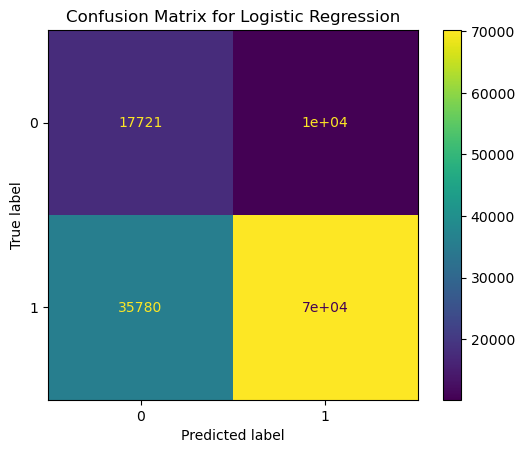

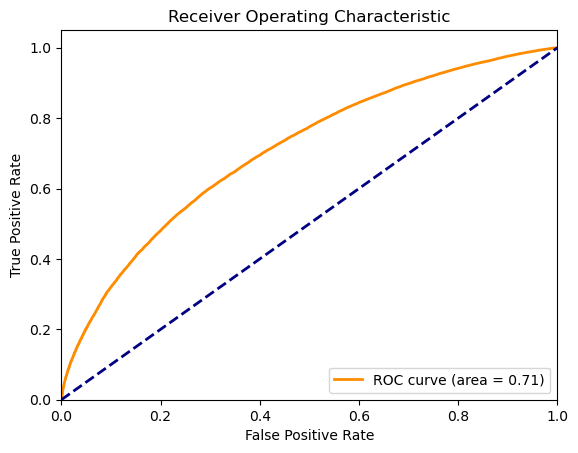

In [37]:

grid_search.cv_results_['mean_test_score']

# Make predictions on the test data
y_pred = best_model.predict(X_test)
class_report = classification_report(y_test, y_pred)
print(class_report)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

###########################################
# ROC CURVE AUC CURVE

# Get the fpr, tpr, thresholds from the probability predict
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Using the gridsearch, there is no improvement over our second iteration. 

***Feature Importance Final Iteration***

In [40]:
# Convert to 1D array
classifier_coefs = best_model.named_steps['classifier'].coef_.flatten()

transformed_feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Which features were kept
selected_features_mask = best_model.named_steps['feature_selection'].get_support()

# Apply the mask to the transformed feature names to get the selected feature names
selected_feature_names = transformed_feature_names[selected_features_mask]

# Use np.where to find indices of features that were not selected
dropped_feature_indices = np.where(selected_features_mask == False)[0]

# Get the names of the dropped features by indexing into the transformed feature names
dropped_feature_names = transformed_feature_names[dropped_feature_indices]

# Print out the dropped features
print("Dropped Features:", dropped_feature_names)

feature_weights_gridsv = pd.DataFrame({
        'Feature': selected_feature_names,
        'Coefficient': classifier_coefs
    })
# Sort the features by the absolute value of their coefficient
feature_weights_gridsv = feature_weights_gridsv.sort_values(by='Coefficient', ascending=True)

Dropped Features: ['cat__home_ownership_ANY' 'cat__home_ownership_NONE'
 'cat__home_ownership_OTHER' 'cat__home_ownership_OWN' 'cat__purpose_car'
 'cat__purpose_debt_consolidation' 'cat__purpose_home_improvement'
 'cat__purpose_house' 'cat__purpose_major_purchase' 'cat__purpose_medical'
 'cat__purpose_moving' 'cat__purpose_other'
 'cat__purpose_renewable_energy' 'cat__purpose_vacation'
 'cat__purpose_wedding' 'cat__application_type_Individual'
 'remainder__acc_now_delinq' 'remainder__tot_coll_amt'
 'remainder__chargeoff_within_12_mths' 'remainder__delinq_amnt'
 'remainder__mo_sin_rcnt_rev_tl_op' 'remainder__mo_sin_rcnt_tl'
 'remainder__num_accts_ever_120_pd']


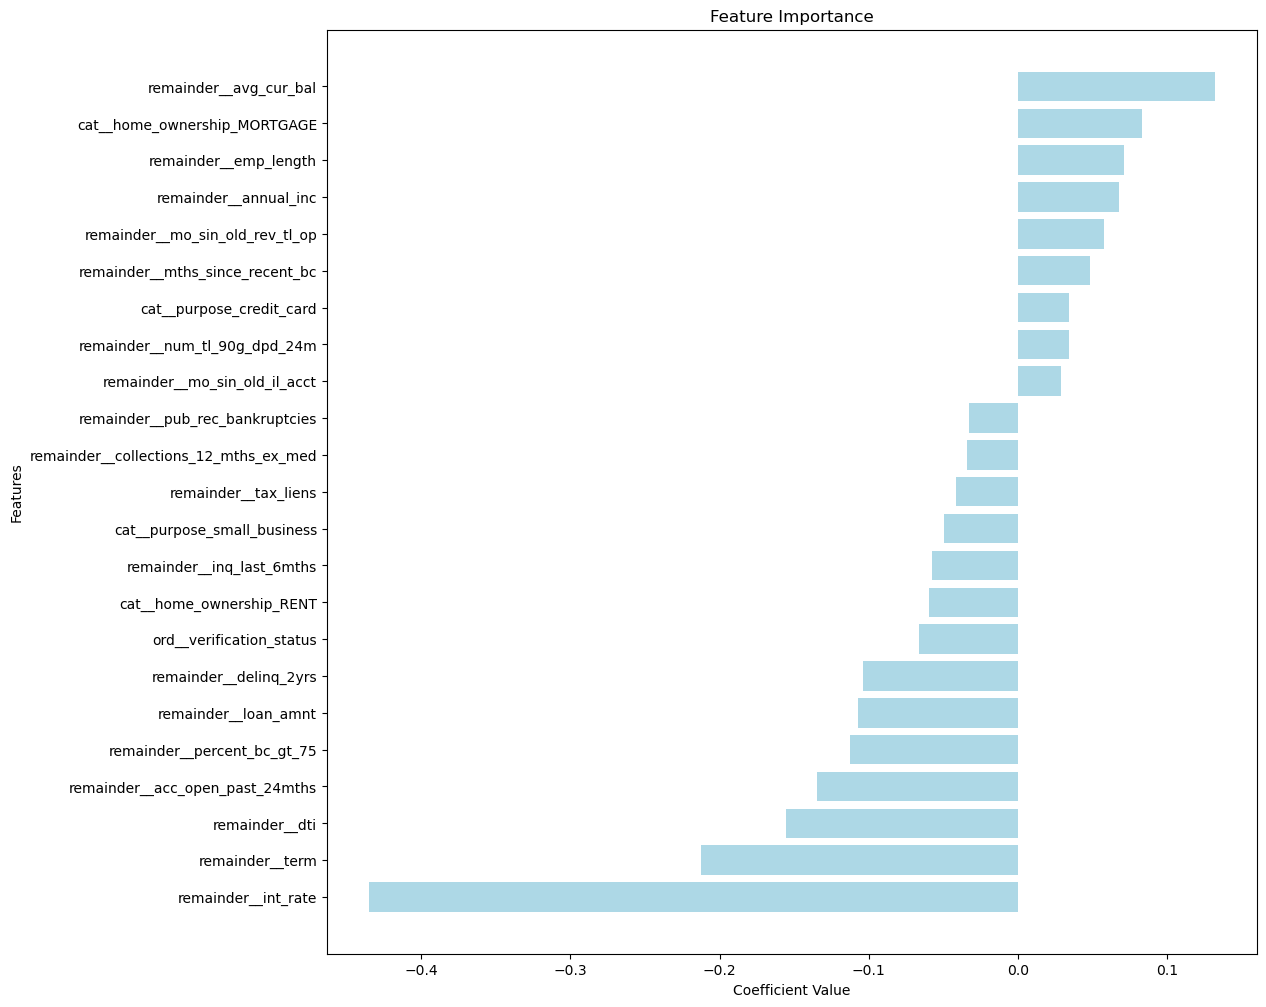

In [41]:
# Plotting the feature weights
plt.figure(figsize=(12, 12))
plt.barh(feature_weights_gridsv['Feature'], feature_weights_gridsv['Coefficient'], color='lightblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

The model achieved the same scores, however many features with little or no predictive value were dropped.

***Vary the threshold***

Plot the precision recall for different thresholds again

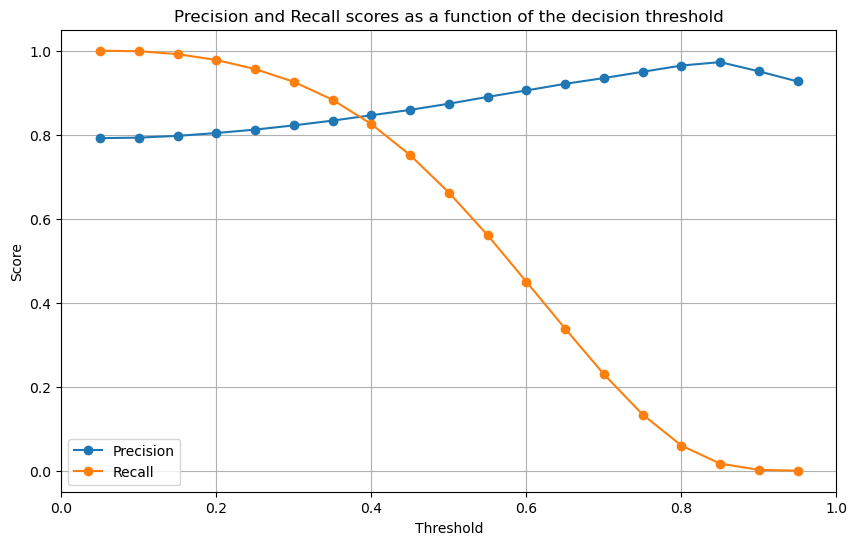

In [42]:
# Vary thresholds by 0.05 from 0.05 to 1
thresholds = np.arange(0.05, 1, 0.05)

precisions = []
recalls = []

for threshold in thresholds:
    # Apply threshold
    y_threshold = np.where(y_proba > threshold, 1, 0)
    
    # Calculate precision and recall
    precision = precision_score(y_test, y_threshold)
    recall = recall_score(y_test, y_threshold)
    
    # Append to list
    precisions.append(precision)
    recalls.append(recall)

# Visualize the result
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.title('Precision and Recall scores as a function of the decision threshold')
plt.xlim(0, 1)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

The Precision and Recall curves are the same as the previous iteration. A threshold of 0.4, 0.5 is suitable.

***Look for common factors in False Positives***

We can examine the false positives next to pinpoint possible problem features for the model, and to see what feature values were potentially leading to the incorrect predictions.

Note: **This is done on the test set, and therefore we CANNOT run another iteration using this information or retroactively change parameters in the pipeline, as that would be leaking data from the test set and could result in inflated metrics and over fitting. This is simply explanatory.**

https://stackoverflow.com/questions/50094999/how-to-return-an-array-of-false-positives-from-a-confusion-matrix-in-scikit-lear

In [43]:
# Transform X_test so it matches the feature names
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

# Get feature names from the pipeline's preprocessor. This list is the full feature list
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Convert to df
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Reset indicies
X_test_transformed_df.reset_index(drop=True, inplace=True)
y_test = y_test.reset_index(drop=True)

# Identify the false positives
false_positives_mask = (y_pred == 1) & (y_test == 0)

# Filter X_test for false positives
false_positives_df = X_test_transformed_df[false_positives_mask.values]

# Store the possible problem features
possible_problem_features = []

for column in false_positives_df.columns:
        
    # Get the most common occurring value in the column 
    mode_value = false_positives_df[column].mode()[0]
    mode_freq = (false_positives_df[column] == mode_value).mean()
    
    # If the column is made up primarily of a single value
    if mode_freq > 0.9:

        possible_problem_features.append(column)
        
        print(f"Feature: {column}")
        print(f"Mode value: {mode_value}")
        print(f"Frequency of mode: {mode_freq}")
        print('-'*20)

Feature: cat__home_ownership_ANY
Mode value: 0.0
Frequency of mode: 0.9998027224304596
--------------------
Feature: cat__home_ownership_NONE
Mode value: 0.0
Frequency of mode: 1.0
--------------------
Feature: cat__home_ownership_OTHER
Mode value: 0.0
Frequency of mode: 1.0
--------------------
Feature: cat__purpose_car
Mode value: 0.0
Frequency of mode: 0.9895442888143618
--------------------
Feature: cat__purpose_home_improvement
Mode value: 0.0
Frequency of mode: 0.9173406983625961
--------------------
Feature: cat__purpose_house
Mode value: 0.0
Frequency of mode: 0.9957585322548826
--------------------
Feature: cat__purpose_major_purchase
Mode value: 0.0
Frequency of mode: 0.9736634444663642
--------------------
Feature: cat__purpose_medical
Mode value: 0.0
Frequency of mode: 0.9863878477017163
--------------------
Feature: cat__purpose_moving
Mode value: 0.0
Frequency of mode: 0.9920102584336161
--------------------
Feature: cat__purpose_other
Mode value: 0.0
Frequency of mode: 0

We can see that for false positives, the onehot encoded category `cat__home_ownership_ANY` as example, is primarily composed of 0 values, and occurs with a frequency of close to 100% among false positives. Meaning, the majority of false positives did not have some form of home ownership. 

This alone does not mean the `home_ownership` feature is a problem for the linear model. It's distribution should be analyzed across the full X_test dataset and then compared to the false positive set in order discern any discrepancy between the two. The other onehot encoded categorical values should also be considered along with the "ANY" flag.  

***PDP graphs***

Partial Dependence Plot (PDP) shows how the model outcome varies with a feature. It shows essentially the type of relationship between a feature and the target variable, allowing us to find any nonlinear relationships that could need potential feature engineering.  
Note that PDP assumes features are independent of one another. 

More information:  
https://www.kaggle.com/code/dansbecker/partial-plots  
https://christophm.github.io/interpretable-ml-book/pdp.html

Length of Features after selection:  23


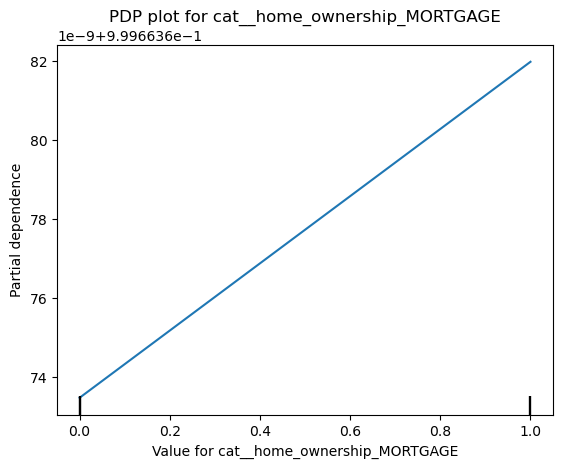

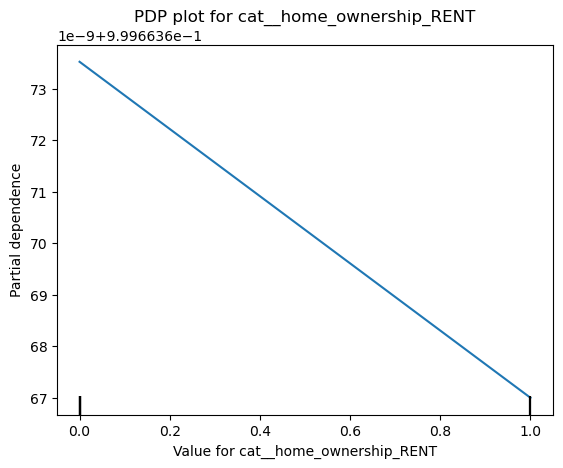

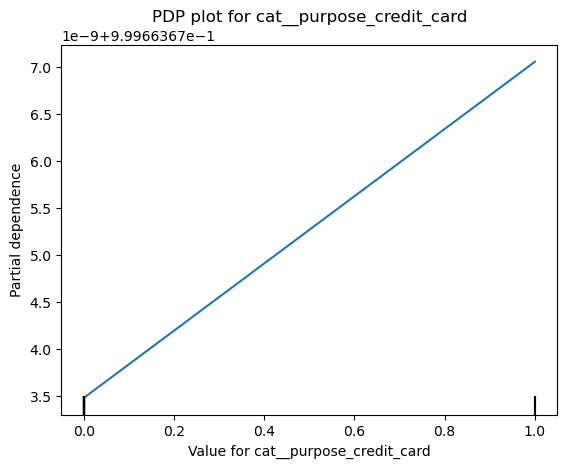

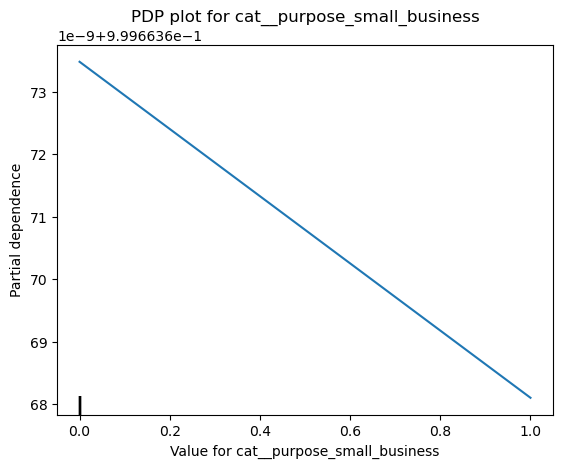

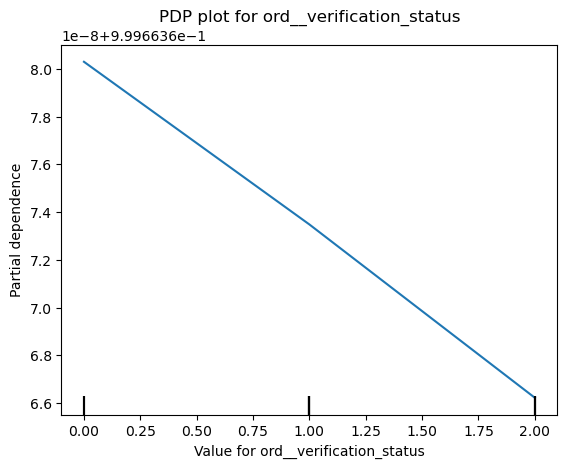

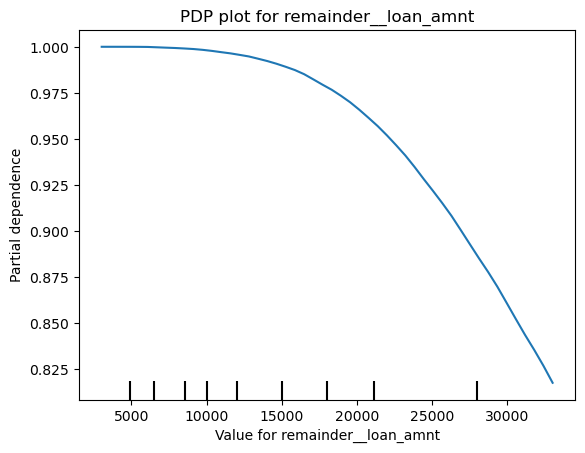

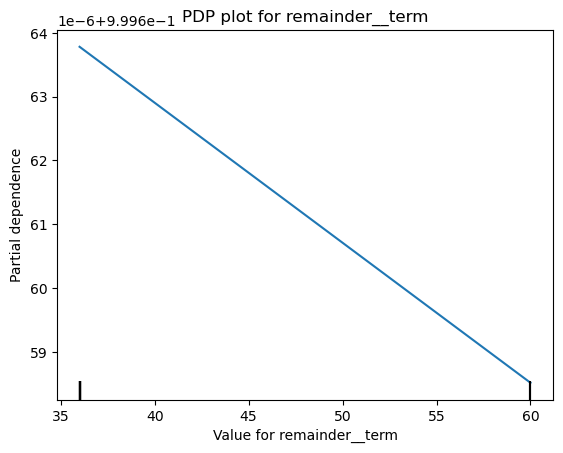

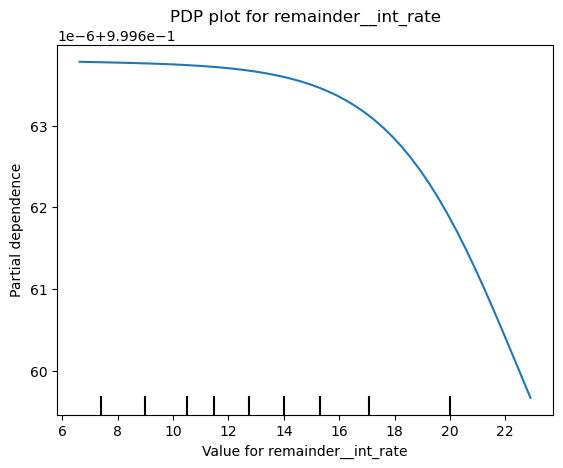

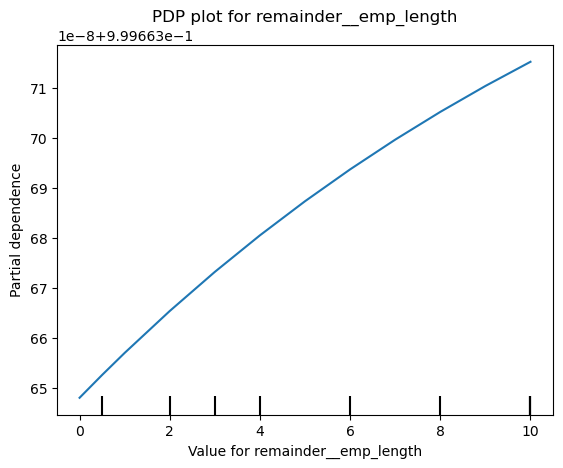

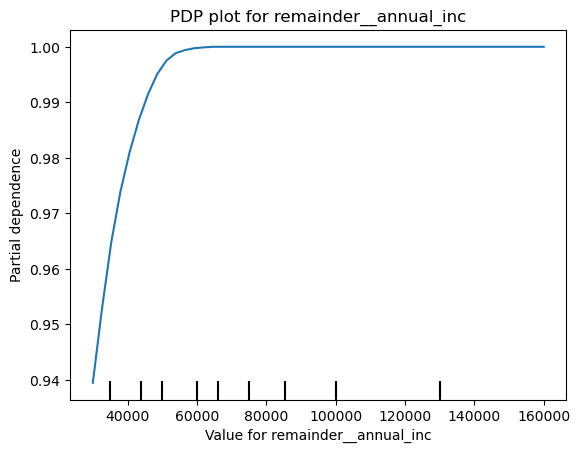

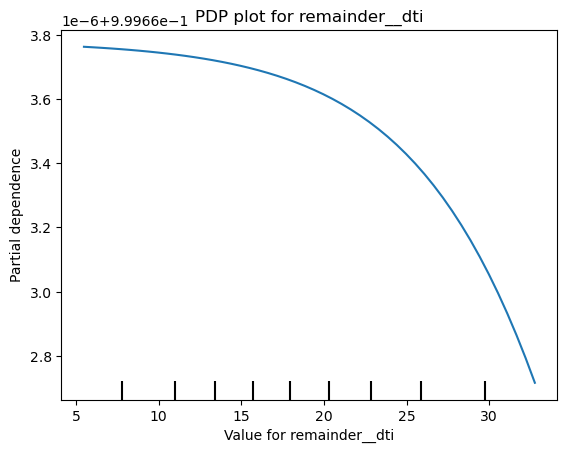

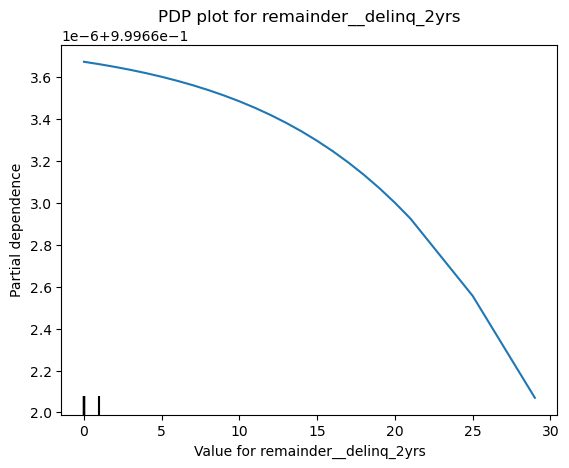

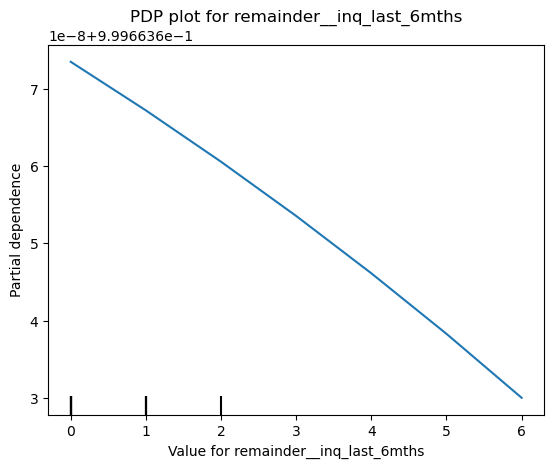

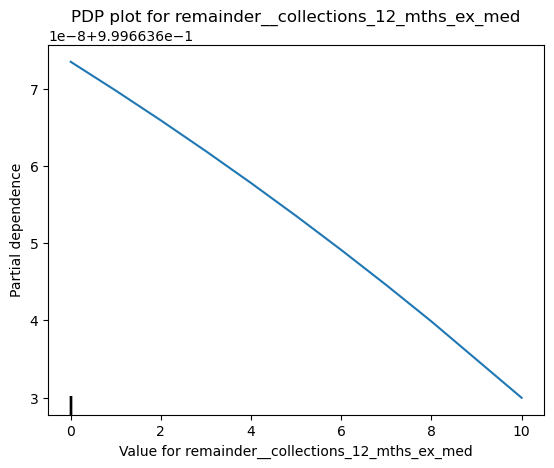

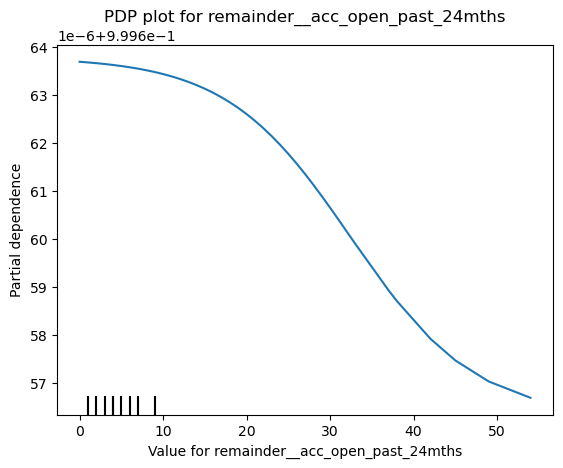

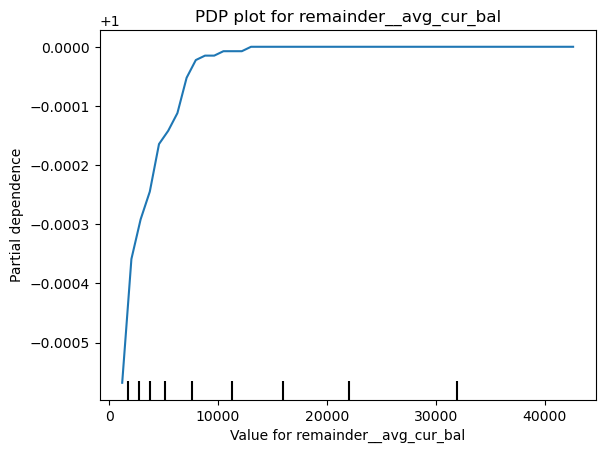

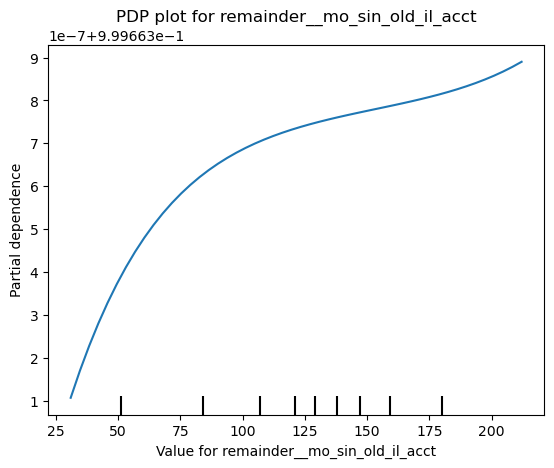

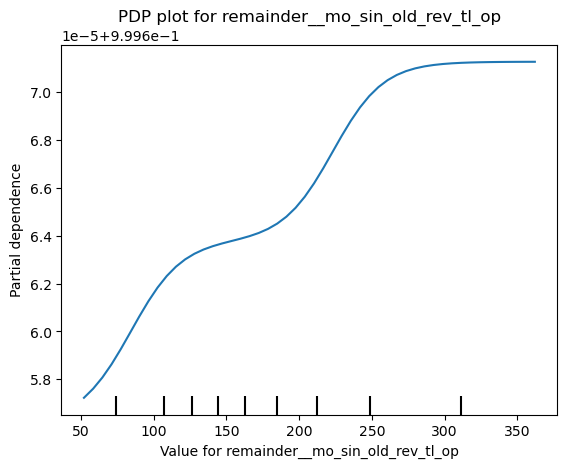

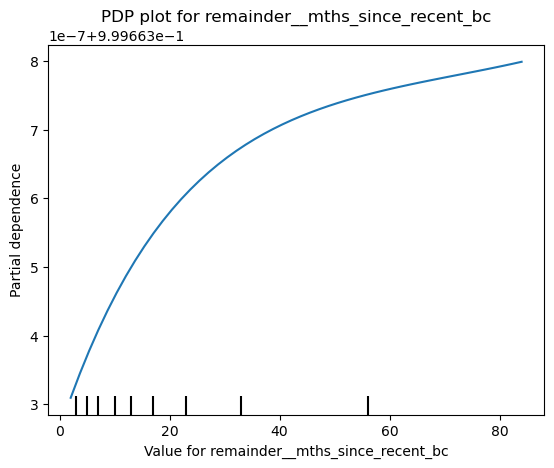

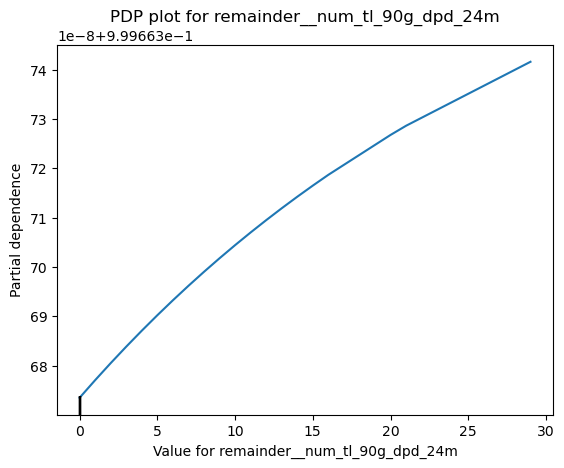

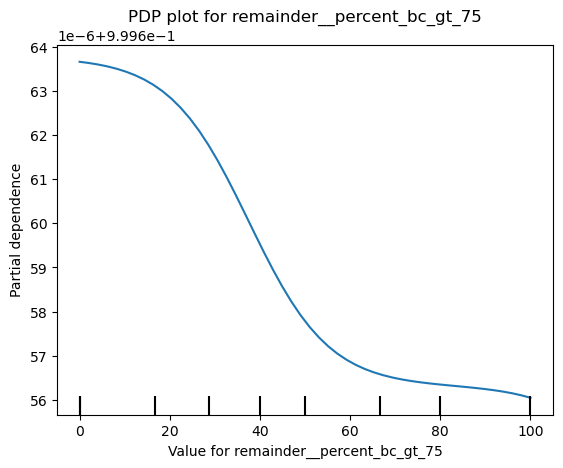

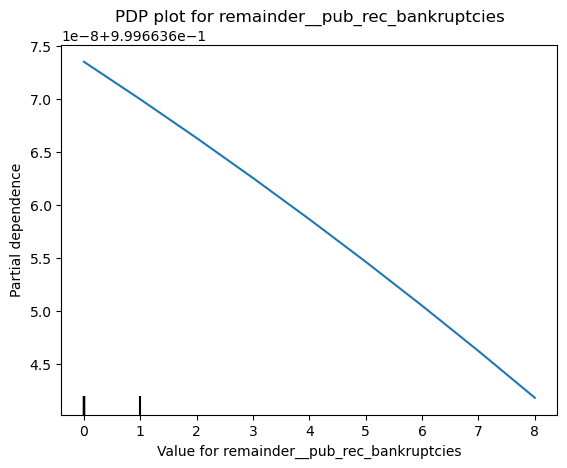

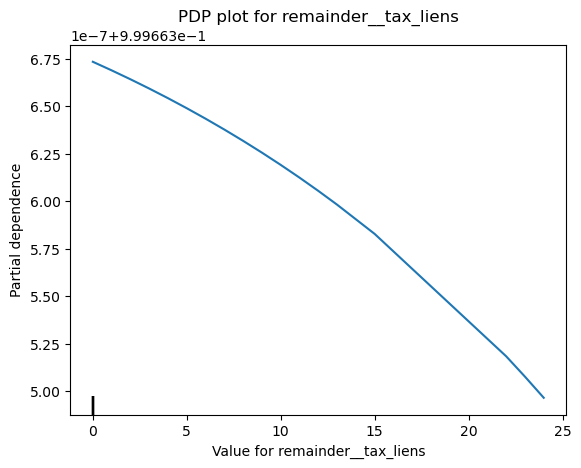

In [88]:
# https://stackoverflow.com/questions/38594734/access-actual-features-after-a-feature-selection-pipeline-in-scikit-learn
# Transform X_test
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)
X_test_transformed = best_model.named_steps['feature_selection'].transform(X_test_transformed)

# The feature names kpet after feature selection
selected_features_mask = best_model.named_steps['feature_selection'].get_support()
feature_names_after_selection = feature_names_transformed[selected_features_mask]

print('Length of Features after selection: ', len(feature_names_after_selection))

for feature_name in feature_names_after_selection:
    # Get the index of the feature_name from feature_names_after_selection
    feature_index = list(feature_names_after_selection).index(feature_name)
    display = PartialDependenceDisplay.from_estimator(
        best_model.named_steps['classifier'],
        X_test_transformed,
        [feature_index],
        grid_resolution=50,
        kind='average'
    )
    plt.title(f"PDP plot for {feature_name}")
    plt.xlabel(f'Value for {feature_name}')
    plt.show()

As shown above, there are many non linear relationships between the features and the target variable. These features could be engineered such that they represent a linear relationship, as example, taking the logarithm if the relationship in exponential. However, it is outside the scope for a baseline linear model. Instead, it will be more effective to focus on SVM's and decision trees next to capture some of this nonlinearity. 

## Conclusion

In this notebook, a baseline log reg model was fitted to the dataset over three iterations. There was a substantial increase in model performance between training on an unbalanced vs scaled balanced dataset, however, hyperparameter tuning offered little improvement. The final model fitted well, with no overfitting or underfitting, and many features were able to be dropped improving model explainability and stability, without impacting performance. Some of the key features found in the final model were the proposed loan interest rate, term, debt to income ratio, employment income, and home ownership status. Log reg decision threshold was varied, and it was found that a 0.4 or default 0.5 cutoff resulted in a good balance between precision and recall, however this can be varied based on lenders risk appetite. Finally, the false positives, representing failed loans misclassified as successful, were inspected for greater insight. It was found there were many features that did not move linearly with the target variable.   

Next steps for the log reg model would be to apply transformations to the features such that the relation between target variable and feature is more linear, allowing the model to better capture more information. 

The final metrics for class 1 optimized log reg were:  
Precision: 0.87  
Recall: 0.66  
F1 score: 0.75  
Auc: 0.71  

Weighted combined f1 score for class 1 and 0: 0.69  